In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import gc 
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import xgboost as xgb
import catboost


from sklearn import model_selection, preprocessing, metrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Фиксируем сид для воспроизводимости.

In [2]:
np.random.seed(13)

# Загрузка данных

In [3]:
train = pd.read_csv('tr3.csv', encoding='cp1251')
test = pd.read_csv('test_before.csv', encoding='cp1251')

In [4]:
diff_columns = train.columns[train.dtypes==object]

### Исследование колонок

In [5]:
diff_columns

Index(['Скважина', 'Дата', 'Характер работы', 'Состояние', 'Вода, т',
       'Жидкость, т', 'Конденсат, т', 'Причина простоя',
       'Обводненность (масса), %', 'Агент закачки', 'Нефть, м3',
       'Жидкость, м3', 'Добыча растворенного газа, м3', 'Тип скважины',
       'Способ эксплуатации', 'Тип насоса', 'Состояние на конец месяца',
       'Дата перевода в ППД', 'work_character', 'completion', 'group'],
      dtype='object')

Небольшой просмотр глазами разных вариантов.

In [6]:
for col in diff_columns:
    tgt = train[col].dropna()
    print(f'{col} with {tgt.nunique()} уникальных значений:\n{", ".join(pd.unique(tgt)[:5])}\n')

Скважина with 175 уникальных значений:
e3cb0f19db24ac4e, 2856e519c47b76c6, caabbe4990b6dd59, 06b4a6ccf91e467c, bb3cad83fefe2ce0

Дата with 310 уникальных значений:
2015-01-01, 2015-02-01, 2015-03-01, 2015-04-01, 2015-05-01

Характер работы with 3 уникальных значений:
НЕФ, НЕФ/НАГ, НАГ

Состояние with 12 уникальных значений:
Б/Д ТГ, РАБ., ОСТ., ОСВ ТГ, Б/Д ПР Л

Вода, т with 3649 уникальных значений:
0,00, 443,69, 541,98, 556,10, 43,82

Жидкость, т with 4378 уникальных значений:
0,00, 1033,69, 1302,56, 1098,72, 837,50

Конденсат, т with 1 уникальных значений:
0,00

Причина простоя with 118 уникальных значений:
Геологич.причина, Нет подачи, Прочие, R=0, Перевод в ППД

Обводненность (масса), % with 985 уникальных значений:
0,0, 42,9, 41,6, 50,6, 5,2

Агент закачки with 12 уникальных значений:
Вода пресная+подтоварная,м.куб.,, Вода пресная+подтоварная,м.куб., Вода подтоварная,м.куб.,, Вода подтоварная,м.куб., Вода сеноманская+подтоварная, м.куб,

Нефть, м3 with 4074 уникальных значений:
0,

In [7]:
cat_cols = ['Состояние', 'Характер работы','Причина простоя','Агент закачки','Тип скважины',
       'Способ эксплуатации', 'Тип насоса', 'Состояние на конец месяца','work_character', 'completion']
string_cols = ['Скважина']
float_cols = ['Жидкость, т','Вода, т','Обводненность (масса), %','Нефть, м3',
       'Жидкость, м3', 'Добыча растворенного газа, м3',]
date_cols = ['Дата',]
drop_cols = ['Конденсат, т',]
date_strange_cols = ['Дата перевода в ППД',]

### Даты

In [8]:
for df in [train, test]:
    df['year'] = pd.DataFrame(df.Дата.apply(lambda x: x.split('-')[0])).astype(int)
    df['month'] = pd.DataFrame(df.Дата.apply(lambda x: x.split('-')[1])).astype(int)
    df.drop('Дата', axis=1, inplace=True)

### Float

In [9]:
train[float_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15040 entries, 0 to 15039
Data columns (total 6 columns):
Жидкость, т                      15040 non-null object
Вода, т                          15040 non-null object
Обводненность (масса), %         15040 non-null object
Нефть, м3                        15040 non-null object
Жидкость, м3                     15040 non-null object
Добыча растворенного газа, м3    15040 non-null object
dtypes: object(6)
memory usage: 705.1+ KB


In [10]:
for df in [train, test]:
    for col in float_cols:
        df[col] = df[col].apply(lambda s: s.replace(',', '.'))
    df[float_cols] = df[float_cols].astype(np.float64)

## Категориальные

In [11]:
np.quantile(train[train.Состояние != 'РАБ.']['Нефть, м3'].dropna(), 0.9)

0.0

In [12]:
for col in cat_cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))
    
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = train[cat_cols].astype('category')


In [13]:
train.head()

,Скважина,Характер работы,Состояние,"Время работы, ч","Нефть, т","Вода, т","Жидкость, т","Попутный газ, м3","Закачка, м3","Природный газ, м3","Газ из газовой шапки, м3","Конденсат, т","Простой, ч",Причина простоя,"Обводненность (масса), %",Агент закачки,"Нефть, м3","Жидкость, м3","Добыча растворенного газа, м3",Тип скважины,Диаметр экспл.колонны,Диаметр НКТ,Диаметр штуцера,Глубина верхних дыр перфорации,Удлинение,Способ эксплуатации,Тип насоса,Производительность ЭЦН,Напор,Частота,Коэффициент сепарации,Глубина спуска,Буферное давление,Давление в линии,Пластовое давление,Динамическая высота,Затрубное давление,Давление на приеме,Забойное давление,Дебит нефти,Дебит жидкости,Обводненность,Состояние на конец месяца,Давление наcыщения,Газовый фактор,Вязкость нефти в пластовых условиях,Вязкость воды в пластовых условиях,Вязкость жидкости в пласт. условиях,объемный коэффициент,Плотность нефти,Плотность воды,Радиус контура питания,Дата ввода в эксплуатацию,Замерное забойное давление,Дата перевода в ППД,Н вд,Н нд,Удл,D э/к,D нкт,Н сп,Приемистость,Р пл,Р заб расчётное,Потери давления на трение,Р затр,Р уст,Закачка за месяц,Рпл,k,Р уст.1,Р заб,work_character,h_vert,pres_atm,heff,d_nkt,cell_area_m2,completion,pres_base_original,bo,kprod_calc,X,Y,group,year,month
0,e3cb0f19db24ac4e,2,2,0,0.00,0.00,0.00,0,0,0,0,"0,00",0,1,0.0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,0,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,-176.055942,267.088631,0051cd92cdc80db1da201362fd8c3355c08eb3a3f76a61...,2015,1
1,e3cb0f19db24ac4e,2,2,0,0.00,0.00,0.00,0,0,0,0,"0,00",0,1,0.0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,0,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2941.0,118.3984,9.59,57.8,218606.0,4,183.661,1.11272,0.00000,-176.055942,267.088631,0051cd92cdc80db1da201362fd8c3355c08eb3a3f76a61...,2015,2
2,e3cb0f19db24ac4e,2,2,0,0.00,0.00,0.00,0,0,0,0,"0,00",0,1,0.0,0,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN,0,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2941.0,118.8716,9.59,57.8,221418.0,4,107.000,1.11272,0.00000,-176.055942,267.088631,0051cd92cdc80db1da201362fd8c3355c08eb3a3f76a61...,2015,3
3,e3cb0f19db24ac4e,2,12,490,590.00,443.69,1033.69,33630,0,0,0,"0,00",0,1,42.9,0,680.51,1122.88,33629.94,0,NaN,NaN,NaN,NaN,NaN,0,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,-176.055942,267.088631,0051cd92cdc80db1da201362fd8c3355c08eb3a3f76a61...,2015,4
4,e3cb0f19db24ac4e,2,12,744,760.58,541.98,1302.56,43353,0,0,0,"0,00",0,1,41.6,0,877.26,1417.62,43353.06,0,NaN,NaN,NaN,NaN,NaN,0,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2941.0,114.5240,4.73,57.8,21313.1,4,107.000,1.11272,1.12669,-176.055942,267.088631,0051cd92cdc80db1da201362fd8c3355c08eb3a3f76a61...,2015,5


Раньше было мало данных.

In [14]:
truncated_train = train[train.year >= 2010]

In [15]:
def get_folds(df=None, n_splits=5):
    unique_vis = np.array(sorted(df['Скважина'].unique()))
    
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['Скважина'].isin(unique_vis[trn_vis])],
                ids[df['Скважина'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [16]:
num_features = list(train.columns[np.logical_or((train.dtypes == np.int64), (train.dtypes== np.float64))]) 
category_features = list(train.columns[train.dtypes== 'category'])

Год и месяц не включаются, что следует отметить.

## Заполнение NAN

In [17]:
for df in [train, test]:
    df[num_features] = df[num_features].fillna(train.append(test).mean())

In [18]:
train[category_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15040 entries, 0 to 15039
Data columns (total 10 columns):
Характер работы              15040 non-null category
Состояние                    15040 non-null category
Причина простоя              15040 non-null category
Агент закачки                15040 non-null category
Тип скважины                 15040 non-null category
Способ эксплуатации          15040 non-null category
Тип насоса                   15040 non-null category
Состояние на конец месяца    15040 non-null category
work_character               15040 non-null category
completion                   15040 non-null category
dtypes: category(10)
memory usage: 176.0 KB


In [19]:
for df in [train, test]:
    for col in category_features:
        df[col] = df[col].cat.add_categories([9999])
        df[col] = df[col].fillna(9999)

In [20]:
train[category_features].head()

,Характер работы,Состояние,Причина простоя,Агент закачки,Тип скважины,Способ эксплуатации,Тип насоса,Состояние на конец месяца,work_character,completion
0,2,2,1,0,0,0,63,0,0,0
1,2,2,1,0,0,0,63,0,1,4
2,2,2,1,0,0,0,63,0,1,4
3,2,12,1,0,0,0,63,0,0,0
4,2,12,1,0,0,0,63,0,1,4


In [21]:
def get_xy(df):
    unique_id = np.array(sorted(df['Скважина'].unique()))
    cols = ['Скважина'] + list(category_features)
    for app in ['mean', 'std', 'max', 'min', 'last', 'minus']:
        cols = cols + [col + f'_{app}' for col in num_features]
    X = pd.DataFrame(columns = cols)
    y_cols = [f'y_{i}' for i in range(12)]+ ['y_mean', 'y_median']
    Y = pd.DataFrame(columns = y_cols)
    for v_id in unique_id:
        tmp =  df[df['Скважина'] == v_id]
        tmp = tmp.sort_values(by=['year', 'month'])
        
        for i in range(6, len(tmp) - 12, 3):
            x_0 = np.array(tmp.iloc[i-1].Скважина)
            x_cat = tmp.iloc[i-1][category_features]
            x_mean = tmp.iloc[i-6:i][num_features].mean()
            x_std = tmp.iloc[i-6:i][num_features].std()
            x_max = tmp.iloc[i-6:i][num_features].max()
            x_min = tmp.iloc[i-6:i][num_features].min()
            x_last = tmp.iloc[i-1][num_features]
            x_minus = tmp.iloc[i-1][num_features] - tmp.iloc[i-6][num_features]
            x = np.hstack((x_0, x_cat, x_mean, x_std, x_max, x_min, x_last, x_minus)).reshape(1, -1)
            x = pd.DataFrame(x, columns=cols)
            
            y = tmp.iloc[i:i+12]['Нефть, м3'].values.flatten()
            y_2 = tmp.iloc[i+6:i+12]['Нефть, м3'].values.flatten()
            y = np.hstack((y, y_2.mean(), np.percentile(y_2, q=50)))
            y = pd.DataFrame(y.reshape(1, -1), columns=y_cols)
            if np.any(y.values > 0):
                X = X.append(x,ignore_index=True)
                Y = Y.append(y, ignore_index=True)
    return X, Y  

In [22]:
def get_test_xy(df):
    unique_id = np.array(sorted(df['Скважина'].unique()))
    cols = ['Скважина'] + list(category_features)
    for app in ['mean', 'std', 'max', 'min', 'last', 'minus']:
        cols = cols + [col + f'_{app}' for col in num_features]
    X = pd.DataFrame(columns = cols)
    for v_id in unique_id:
        tmp =  df[df['Скважина'] == v_id]
        tmp = tmp.sort_values(by=['year', 'month'])
        
        x_0 = np.array(tmp.iloc[-1].Скважина)
        x_cat = tmp.iloc[-1][category_features]
        x_mean = tmp.iloc[-6:][num_features].mean()
        x_std = tmp.iloc[-6:][num_features].std()
        x_max = tmp.iloc[-6:][num_features].max()
        x_min = tmp.iloc[-6:][num_features].min()
        x_last = tmp.iloc[-1][num_features]
        if tmp.shape[0] >= 6:
            x_minus = tmp.iloc[-1][num_features] - tmp.iloc[-6][num_features]
        else:
            x_minus = tmp.iloc[-1][num_features] - tmp.iloc[0][num_features]
        x = np.hstack((x_0, x_cat, x_mean, x_std, x_max, x_min, x_last, x_minus)).reshape(1, -1)
        x = pd.DataFrame(x, columns=cols)
        X = X.append(x,ignore_index=True)
    return X

In [23]:
gc.collect()

35

## First train

In [24]:
X_test = get_test_xy(test)

In [25]:
X_train, Y_train = get_xy(truncated_train.append(test))

In [26]:
X_test = get_test_xy(test)

In [27]:
gc.collect()

609

In [28]:
X_train.shape

(2215, 437)

In [29]:
Y_train.head()

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_mean,y_median
0,406.0,400.0,274.0,326.0,324.0,303.0,315.0,316.0,359.0,377.00,356.00,399.00,353.666667,357.50
1,326.0,324.0,303.0,315.0,316.0,359.0,377.0,356.0,399.0,365.00,355.00,374.00,371.000000,369.50
2,315.0,316.0,359.0,377.0,356.0,399.0,365.0,355.0,374.0,317.00,341.00,363.00,352.500000,359.00
3,377.0,356.0,399.0,365.0,355.0,374.0,317.0,341.0,363.0,362.00,378.00,297.00,343.000000,351.50
4,365.0,355.0,374.0,317.0,341.0,363.0,362.0,378.0,297.0,425.62,392.88,380.08,372.596667,379.04


In [30]:
folds = get_folds(X_train)

In [31]:
for df in X_train, X_test:
    tr_cat = list(category_features)
    df[tr_cat] = df[tr_cat].astype('category')

    tr_num = list()
    for app in ['mean', 'std', 'max', 'min', 'last', 'minus']:
        tr_num = tr_num + [col + f'_{app}' for col in num_features]
    df[tr_num] = df[tr_num].astype(np.float64)



In [32]:
category_features

['Характер работы',
 'Состояние',
 'Причина простоя',
 'Агент закачки',
 'Тип скважины',
 'Способ эксплуатации',
 'Тип насоса',
 'Состояние на конец месяца',
 'work_character',
 'completion']

In [33]:
cat_idx = []
for i, name in enumerate(X_train.columns):
    if name in list(category_features):
        cat_idx.append(i)

In [34]:
def predict(tgt='y_median'):
    np.random.seed(12)
    train_features = tr_cat + tr_num

    oof_reg_preds = np.zeros(X_train.shape[0])
    sub_reg_preds = []
    imp_reg_pred = []
    for fold_, (trn_, val_) in enumerate(folds):
        trn_x, trn_y = X_train[train_features].iloc[trn_], Y_train.iloc[trn_][tgt]
        val_x, val_y = X_train[train_features].iloc[val_], Y_train.iloc[val_][tgt]

        reg = lgb.LGBMRegressor(
            metric='l1',
            num_leaves=31,
            learning_rate=0.03,
            n_estimators=1000,
            subsample=.9,
            colsample_bytree=.9,
            random_state=1
        )
        reg.fit(
            trn_x, trn_y,
            eval_set=[(val_x, val_y)],
            early_stopping_rounds=100,
            verbose=100,
            eval_metric='rmse'
        )
        oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
        
        oof_reg_preds[oof_reg_preds < 0] = 0
            
        _preds = reg.predict(X_test[train_features], num_iteration=reg.best_iteration_)
        _preds[_preds < 0] = 0
        sub_reg_preds.append(_preds) 
        
    sub_reg_preds = np.mean(np.array(sub_reg_preds), axis=0)

    print(tgt, mean_absolute_error(Y_train[tgt], oof_reg_preds))
    return sub_reg_preds, mean_absolute_error(Y_train[tgt], oof_reg_preds), oof_reg_preds

### lgbm

In [35]:
y_i = []
mae = []
y_i_train = []
for i in range(12):
    a, b , c = predict(f'y_{i}')
    y_i.append(a)
    mae.append(b)
    y_i_train.append(c)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 125.912	valid_0's l1: 66.6695
[200]	valid_0's rmse: 127.493	valid_0's l1: 63.6951
Early stopping, best iteration is:
[110]	valid_0's rmse: 125.533	valid_0's l1: 65.1909
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 154.795	valid_0's l1: 63.4362
[200]	valid_0's rmse: 148.121	valid_0's l1: 61.7463
Early stopping, best iteration is:
[121]	valid_0's rmse: 150.854	valid_0's l1: 61.2246
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 98.174	valid_0's l1: 57.6128
Early stopping, best iteration is:
[98]	valid_0's rmse: 98.0161	valid_0's l1: 57.8521
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 120.664	valid_0's l1: 68.1266
[200]	valid_0's rmse: 114.884	valid_0's l1: 64.6428
Early stopping, best iteration is:
[151]	valid_0's rmse: 114.194	valid_0's l1: 64.2811
Training until validation scores don't

[200]	valid_0's rmse: 267.268	valid_0's l1: 148.408
Early stopping, best iteration is:
[154]	valid_0's rmse: 264.658	valid_0's l1: 146.762
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 211.971	valid_0's l1: 122.545
[200]	valid_0's rmse: 209.758	valid_0's l1: 119.675
Early stopping, best iteration is:
[125]	valid_0's rmse: 208.701	valid_0's l1: 119.908
y_6 129.66319378396605
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 254.394	valid_0's l1: 146.736
[200]	valid_0's rmse: 254.512	valid_0's l1: 143.123
Early stopping, best iteration is:
[145]	valid_0's rmse: 252.602	valid_0's l1: 142.494
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 229.956	valid_0's l1: 122.16
[200]	valid_0's rmse: 225.502	valid_0's l1: 121.164
Early stopping, best iteration is:
[168]	valid_0's rmse: 226.463	valid_0's l1: 120.637
Training until validation scores don't improve for 100 rounds.
[100]	valid_0'

In [36]:
mae

[62.97677586728031,
 79.34227688028234,
 93.85846058042252,
 106.79917848080527,
 113.9393389201976,
 123.70011510649559,
 129.66319378396605,
 134.975536833622,
 133.0515676205163,
 137.63457355515936,
 144.69154436470055,
 142.2391866739182]

In [67]:
mae

[63.283597965942256,
 79.21588073087446,
 98.58814075137644,
 110.90345058155387,
 117.84204180975122,
 123.33349963927861,
 130.11018489735136,
 133.16556938318175,
 136.75547031555345,
 140.1079811845784,
 141.71633984956856,
 146.264803340863]

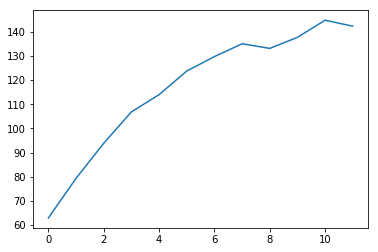

In [37]:
plt.plot(mae)

In [38]:
first_index = X_test.Скважина

In [39]:
first_index= list(first_index)

In [40]:
mapping = dict(((name, i) for i, name in enumerate(first_index)))

In [41]:
order = pd.read_csv('order3.csv')
order.columns = ['id', 'Скважина']
order = order.Скважина.values

In [42]:
answ = []
for idd in order:
    for i in range(12):
        answ.append(y_i[i][mapping[idd]])

In [43]:
res = pd.DataFrame({'_VAL_':answ})
res.index.name = '_ID_'

In [44]:
res.to_csv('submission_x.csv')

In [45]:
res.head()

,_VAL_
_ID_,
0,292.408374
1,237.299947
2,236.588815
3,257.662889
4,228.211204


In [46]:
y_res = pd.DataFrame(dict(((f'y_{i}', y_i_train[i]) for i in range(12))))
y_res_i = pd.DataFrame(dict(((f'y_{i}', y_i[i]) for i in range(12))))
Y_tr = Y_train.drop('y_mean', axis=1)
Y_tr = Y_tr.drop('y_median', axis=1)

In [49]:
def predict_Linear(tgt='y_0'):
    np.random.seed(12)
    oof_reg_preds = np.zeros(X_train.shape[0])
    sub_reg_preds = []
    
    for fold_, (trn_, val_) in enumerate(folds):
        print(f'{fold_} started!')
        trn_x, trn_y = y_res.iloc[trn_], Y_tr.iloc[trn_][tgt]
        val_x, val_y = y_res.iloc[val_], Y_tr.iloc[val_][tgt]
        
        reg = LinearRegression()
        
        reg.fit(
            trn_x, trn_y
        )
        oof_reg_preds[val_] = reg.predict(val_x)
        
        oof_reg_preds[oof_reg_preds < 0] = 0
            
        _preds = reg.predict(y_res_i)
        _preds[_preds < 0] = 0
        sub_reg_preds.append(_preds) 
    sub_reg_preds = np.percentile(np.array(sub_reg_preds), 50, axis=0)
    print(tgt, mean_absolute_error(Y_train[tgt], oof_reg_preds))
    return sub_reg_preds, mean_absolute_error(Y_train[tgt], oof_reg_preds), oof_reg_preds

In [50]:
l_y_i = []
l_mae = []
l_y_i_train = []
for i in range(12):
    a, b, c = predict_Linear(f'y_{i}')
    l_y_i.append(a)
    l_mae.append(b)
    l_y_i_train.append(c)

0 started!
1 started!
2 started!
3 started!
4 started!
y_0 62.55968036287536
0 started!
1 started!
2 started!
3 started!
4 started!
y_1 77.2223875341363
0 started!
1 started!
2 started!
3 started!
4 started!
y_2 89.03907985909906
0 started!
1 started!
2 started!
3 started!
4 started!
y_3 100.40297868461744
0 started!
1 started!
2 started!
3 started!
4 started!
y_4 105.15637340998681
0 started!
1 started!
2 started!
3 started!
4 started!
y_5 111.82210135346214
0 started!
1 started!
2 started!
3 started!
4 started!
y_6 118.30411388014848
0 started!
1 started!
2 started!
3 started!
4 started!
y_7 119.83837675736632
0 started!
1 started!
2 started!
3 started!
4 started!
y_8 123.30947936883656
0 started!
1 started!
2 started!
3 started!
4 started!
y_9 127.21739493626964
0 started!
1 started!
2 started!
3 started!
4 started!
y_10 129.32818029237342
0 started!
1 started!
2 started!
3 started!
4 started!
y_11 133.98798286688702


In [51]:
np.array(l_mae) - np.array(mae)

array([ -0.4170955 ,  -2.11988935,  -4.81938072,  -6.3961998 ,
        -8.78296551, -11.87801375, -11.3590799 , -15.13716008,
        -9.74208825, -10.41717862, -15.36336407,  -8.25120381])

In [52]:
new_y = []
new_y.append(y_i[0])
new_y.append(y_i[1])
for i in range(2, 12):
    new_y.append(l_y_i[i])

In [53]:
first_index = X_test.Скважина
first_index= list(first_index)
mapping = dict(((name, i) for i, name in enumerate(first_index)))
order = pd.read_csv('order3.csv')
order.columns = ['id', 'Скважина']
order = order.Скважина.values

answ = []
for idd in order:
    for i in range(12):
        answ.append(new_y[i][mapping[idd]]*0.96)
        

        res = pd.DataFrame({'_VAL_':answ})
res.index.name = '_ID_'

In [54]:
res.to_csv('submission_new.csv')